
**Install requirements**

In [0]:
"""!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'"""

"!pip3 install 'torch==1.3.1'\n!pip3 install 'torchvision==0.5.0'\n!pip3 install 'Pillow-SIMD'\n!pip3 install 'tqdm'"

**Import libraries**

In [0]:
import os
import logging
import copy
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.models import vgg16

from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import StratifiedShuffleSplit

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2       # The initial Learning Rate, ORIGINAL: 1e-3
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset), original: 30
STEP_SIZE = 40      # How many epochs before decreasing learning rate (if using a step-down policy), original: 20
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

# MY PARAMS
LAYERS = 'FC' #NORMAL, CONVOLUTIONAL, FC
DATA_AUGMENTATION = False #TRUE, FALSE
CHOSEN_NETWORK = 'ALEXNET' #ALEXNET, VGG

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Define Data Preprocessing (Pretrained AlexNet)**

In [0]:
mean_pretrained = (0.485, 0.456, 0.406)
stDev_pretrained = (0.229, 0.224, 0.225)
img_eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = mean_pretrained,std= stDev_pretrained)
])


img_train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = mean_pretrained,std= stDev_pretrained)
])

**Data Augmentation**

In [0]:
# DATA AUGMENTATION TRANSFORMATIONS

# 1 - RANDOM CROP
random_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.RandomCrop(224),  # Crops a random square patch of the image => difference from before
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean_pretrained, stDev_pretrained) # Normalizes tensor with mean and standard deviation
                                      ])

# 2 - HORIZONTAL FLIP
flip_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.RandomHorizontalFlip(0.5), 
                                      transforms.CenterCrop(224),  # Crops a random square patch of the image                                      
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean_pretrained, stDev_pretrained) # Normalizes tensor with mean and standard deviation
                                      ])
# 3 - RANDOM FLIP -- not used 
"""random_flip_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.RandomCrop(224),  # Crops a random square patch of the image
                                      transforms.RandomHorizontalFlip(1.0), 
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean_pretrained, stDev_pretrained) # Normalizes tensor with mean and standard deviation
                                      ])"""

# 4 - GRAY SCALE
greyscale_transform = transforms.Compose([transforms.RandomGrayscale(0.5),
                                      transforms.Resize(256), 
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=mean_pretrained, std=stDev_pretrained) 
                                      ])


**Caltech.py embedding**

In [0]:
from torchvision.datasets import VisionDataset

from PIL import Image

import os
import os.path
import sys

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def make_dataset(dir, class_to_idx, extensions=None, is_valid_file=None, split='train', transf='None'):
    images = []
    dir = os.path.expanduser(dir)
    if not ((extensions is None) ^ (is_valid_file is None)):
        raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
    if extensions is not None:
        def is_valid_file(x):
            return x.lower().endswith(extensions)

    inFile = os.path.join(dir, split + '.txt')
    with open(inFile, 'r') as f:      
      inImages = f.read().splitlines()

    root = os.path.join(dir, '101_ObjectCategories/')

    for fname in sorted(inImages):
      fpath = os.path.split(fname)
      target = fpath[0]
      path = os.path.join(root, fname)
      if is_valid_file(path) and target != 'BACKGROUND_Google':
        image = pil_loader(path)        
        if transf is not None:
            image = transf(image) # Applies preprocessing
        item = (image, class_to_idx[target])
        images.append(item)

    return images

class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')

        classes, class_to_idx = self._find_classes(self.root)
        samples = make_dataset(self.root, class_to_idx, IMG_EXTENSIONS, split=self.split, transf=transform)
        if len(samples) == 0:
            raise (RuntimeError("Found 0 files in subfolders of: " + self.root + "\n"
                                "Supported extensions are: " + ",".join(extensions)))


        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.root = root
        self.targets = [s[1] for s in samples]

    def _find_classes(self, dir):        
        root = os.path.join(dir, '101_ObjectCategories/')
        if sys.version_info >= (3, 5):
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(root) if d.is_dir()]
        else:          
            classes = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
        
        classes.remove('BACKGROUND_Google')
        classes.sort()                
        #print(classes)
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''

        image, label = self.samples[index]        
        return image, label

    def getAllTargets(self):
      return self.targets

    def __len__(self):        
        return len(self.samples)

**Prepare Dataset**

In [0]:
from math import floor
import numpy as np

# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/'
TRAIN_SPLIT = 'train'
TEST_SPLIT = 'test'

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split=TRAIN_SPLIT,  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split=TEST_SPLIT, transform=eval_transform)

#from Caltech101.caltech_dataset import Caltech

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9256, done.
remote: Total 9256 (delta 0), reused 0 (delta 0), pack-reused 9256
Receiving objects: 100% (9256/9256), 129.48 MiB | 40.23 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (9149/9149), done.


**Train and validation split**

In [0]:
train_dataset_len = len(train_dataset)
val_dataset_size = 0.5

# 2A
y = np.array(train_dataset.getAllTargets())
X = np.zeros(len(y))
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_dataset_size, random_state=42)
sss.get_n_splits(X, y)

# just one iteration
for train_indexes, val_indexes in sss.split(X, y):
  val_dataset = Subset(train_dataset, val_indexes)
  splitted_train_dataset = Subset(train_dataset, train_indexes)

print('Train Dataset: {}'.format(len(splitted_train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare dataset (pretrained AlexNet)**

In [0]:
# Prepare Pytorch train/test Datasets
img_train_dataset = Caltech(DATA_DIR, split=TRAIN_SPLIT,  transform=img_train_transform)
img_test_dataset = Caltech(DATA_DIR, split=TEST_SPLIT, transform=img_eval_transform)

# data augmentation (done only for pretrained net)
if (DATA_AUGMENTATION):

  # RANDOM CROP
  augmented_train_dataset = Caltech(DATA_DIR, split='train', transform=random_transform)
  augmented_test_dataset = Caltech(DATA_DIR, split='test', transform=random_transform)
  # no need to data aug the test set
  img_train_dataset.samples += augmented_train_dataset.samples

  # HORIZONTAL FLIP
  augmented_train_dataset = Caltech(DATA_DIR, split='train', transform=flip_transform)
  augmented_test_dataset = Caltech(DATA_DIR, split='test', transform=flip_transform)
  img_train_dataset.samples += augmented_train_dataset.samples

  # RANDOM FLIP
  """augmented_train_dataset = Caltech(DATA_DIR, split='train', transform=random_flip_transform)
  augmented_test_dataset = Caltech(DATA_DIR, split='test', transform=random_flip_transform)
  img_train_dataset.samples += augmented_train_dataset.samples"""

  # GREYSCALE TRANSFORMATION
  """augmented_train_dataset = Caltech(DATA_DIR, split='train', transform=greyscale_transform)
  augmented_test_dataset = Caltech(DATA_DIR, split='test', transform=greyscale_transform)
  img_train_dataset.samples += augmented_train_dataset.samples"""


img_splitted_train_dataset = Subset(train_dataset, train_indexes)
img_val_dataset = Subset(train_dataset, val_indexes)

**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(splitted_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Dataloaders (pretrained AlexNet)**

In [0]:
img_train_dataloader = DataLoader(img_splitted_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
img_val_dataloader = DataLoader(img_val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
img_test_dataloader = DataLoader(img_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network (both scratch and pretrained)**

In [0]:
if CHOSEN_NETWORK == 'ALEXNET':
  net = alexnet() # Loading AlexNet model
  bestnet = alexnet() # Instance where the best network will be copied for the validation phase
  pretrainednet = alexnet(pretrained=True) # Instance where the best network will be copied for the validation phase
elif CHOSEN_NETWORK == 'VGG':
  net = vgg16() 
  bestnet = vgg16() 
  pretrainednet = vgg16(pretrained=True)


# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
bestnet.classifier[6] = nn.Linear(4096, NUM_CLASSES)
pretrainednet.classifier[6] = nn.Linear(4096, NUM_CLASSES)


# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


**Prepare Training (both scratch and pretrained)**

In [0]:
# MOST OF THE LINES OF THIS BLOCK HAVE BEEN EMBEDDED IN THE COMMON FUNCTION

# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# i could squeeze all of the below in the common function

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
# In this case we optimize over all the parameters of AlexNet
bestnet_parameters_to_optimize = bestnet.parameters()
if (LAYERS == 'NORMAL'): # complete architecture
  pretrainednet_parameters_to_optimize = pretrainednet.parameters()
  parameters_to_optimize = net.parameters() 
elif (LAYERS == 'CONVOLUTIONAL'): # freeze fully connected
  pretrainednet_parameters_to_optimize = pretrainednet.features.parameters()
  parameters_to_optimize = net.features.parameters() 
elif (LAYERS == 'FC'): # freeze covolutional
  pretrainednet_parameters_to_optimize = pretrainednet.classifier.parameters()
  parameters_to_optimize = net.classifier.parameters()

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
bestnet_optimizer = optim.SGD(bestnet_parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
pretrainednet_optimizer = optim.SGD(pretrainednet_parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)



# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
bestnet_scheduler = optim.lr_scheduler.StepLR(bestnet_optimizer, step_size=STEP_SIZE, gamma=GAMMA)
pretrainednet_scheduler = optim.lr_scheduler.StepLR(pretrainednet_optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
def validateTest(nnet, loader, dataset):
  nnet = nnet.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  nnet.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in tqdm(loader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = nnet(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(dataset))
  return accuracy


In [0]:
def output(accuracy, accuraciesValidation, accuraciesTraining, lossesValidation, epochs_list):
  print('FINAL: Test Accuracy: {}'.format(accuracy))

  ###########
  # Plots
  ###########
  epochsAccuracies = list(zip(epochs_list, accuraciesValidation, accuraciesTraining))
  dataEpochsAccuracy = pd.DataFrame(epochsAccuracies, columns = ['Epochs', 'Accuracy validation', 'Accuracy training'])

  # epochs against accuracy
  ax = sns.lineplot(x="Epochs", y="Accuracy validation", data=dataEpochsAccuracy)
  ax = sns.lineplot(x="Epochs", y="Accuracy training", data=dataEpochsAccuracy)
  ax.legend(['Accuracy validation','Accuracy training'])
  ax.set(xlabel='Epochs', ylabel='Accuracy')
  plt.show()
  
  # epochs against loss
  epochsLosses = list(zip(epochs_list, lossesValidation))
  dataEpochsLosses = pd.DataFrame(epochsLosses, columns = ['Epochs', 'Loss'])

  ax1 = sns.lineplot(x="Epochs", y="Loss", data=dataEpochsLosses)
  plt.show()


***Common function***

In [0]:
def trainValidateTest(mode, selNet, selOptimizer, selScheduler, selLR, selNEpochs, selStepSize, selTrainLoader, selValLoader, selTestLoader, selTrainingDataset, selValidationDataset, selTestDataset):
  # By default, everything is loaded to cpu

  selNet = selNet.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0

  training_accuracies = []
  accuracies = []
  losses = []
  epochs_list = []

  # keep track of accuracy and loss, in order to save the best trained network
  # i start from the worst scenario possible
  best_accuracy = float('-inf') #minimum possible value in Python
  best_loss = float('inf')

  # Start iterating over the epochs
  for epoch in range(selNEpochs):
    print('\nStarting epoch {}/{}, LR = {}'.format(epoch+1, selNEpochs, selScheduler.get_lr()))

    # Iterate over the dataset
    for images, labels in selTrainLoader:
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      selNet.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      selOptimizer.zero_grad() # Zero-ing the gradients

      # Forward pass to the network
      outputs = selNet(images)

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      selOptimizer.step() # update weights based on accumulated gradients

      current_step += 1

    # Training set accuracy
    training_accuracy = validateTest(selNet, selTrainLoader, selTrainingDataset)
    training_accuracies.append(training_accuracy)

    ###################
    # VALIDATION PHASE
    ###################
    # (at the end of each epoch)
    # implementing of model selection with validation

    accuracy = validateTest(selNet, selValLoader, selValidationDataset)
    print('Validation Accuracy: {}'.format(accuracy))
    accuracies.append(accuracy)
    losses.append(loss.item())
    epochs_list.append(epoch)

    # shoud i update my best model?
    # i choose based on accuracy and loss (in this order)
    if accuracy > best_accuracy:
      bestnet = copy.deepcopy(selNet)
      best_accuracy = accuracy
    elif accuracy == best_accuracy:
      if loss.item() < best_loss:
        best_loss = loss.item()
        bestnet = copy.deepcopy(selNet) 
    
    # Step the scheduler
    selScheduler.step() 




  #############
  # TEST PHASE
  #############
  # i want to test on the best model
 
  accuracy = validateTest(bestnet, selTestLoader, selTestDataset)

  ##########
  # Output
  ##########
  output(accuracy, accuracies, training_accuracies, losses, epochs_list)



In [0]:
# train from scratch

#trainValidateTest("Training from scratch", net, optimizer, scheduler, LR, NUM_EPOCHS, STEP_SIZE, train_dataloader, val_dataloader, test_dataloader,splitted_train_dataset, val_dataset, test_dataset)


Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.860447883605957
Step 10, Loss 1.8766950368881226


100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

Validation Accuracy: 0.6414246196403873

Starting epoch 2/30, LR = [0.01]


Step 20, Loss 0.7005923390388489


100%|██████████| 12/12 [00:03<00:00,  3.97it/s]

Validation Accuracy: 0.7793914246196404

Starting epoch 3/30, LR = [0.01]


Step 30, Loss 0.4092668294906616


100%|██████████| 12/12 [00:02<00:00,  4.08it/s]

Validation Accuracy: 0.7942600276625172

Starting epoch 4/30, LR = [0.01]


Step 40, Loss 0.2198803722858429


100%|██████████| 12/12 [00:03<00:00,  4.00it/s]

Validation Accuracy: 0.8091286307053942

Starting epoch 5/30, LR = [0.01]


Step 50, Loss 0.10416561365127563


100%|██████████| 12/12 [00:03<00:00,  3.98it/s]

Validation Accuracy: 0.822268326417704

Starting epoch 6/30, LR = [0.01]


Step 60, Loss 0.08423440158367157


100%|██████████| 12/12 [00:02<00:00,  4.19it/s]

Validation Accuracy: 0.8226141078838174

Starting epoch 7/30, LR = [0.01]


Step 70, Loss 0.09682168811559677


100%|██████████| 12/12 [00:02<00:00,  4.20it/s]

Validation Accuracy: 0.822268326417704

Starting epoch 8/30, LR = [0.01]


Step 80, Loss 0.0450066402554512


100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

Validation Accuracy: 0.822268326417704

Starting epoch 9/30, LR = [0.01]


Step 90, Loss 0.053278036415576935


100%|██████████| 12/12 [00:02<00:00,  4.19it/s]

Validation Accuracy: 0.8215767634854771

Starting epoch 10/30, LR = [0.01]


Step 100, Loss 0.04528672993183136


100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

Validation Accuracy: 0.8253803596127247

Starting epoch 11/30, LR = [0.01]


Step 110, Loss 0.04928011819720268


  0%|          | 0/11 [00:00<?, ?it/s]

Step 120, Loss 0.03186044842004776


100%|██████████| 12/12 [00:02<00:00,  4.22it/s]

Validation Accuracy: 0.8257261410788381

Starting epoch 12/30, LR = [0.01]


Step 130, Loss 0.027917973697185516


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]

Validation Accuracy: 0.8319502074688797

Starting epoch 13/30, LR = [0.01]


Step 140, Loss 0.028302334249019623


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]

Validation Accuracy: 0.828838174273859

Starting epoch 14/30, LR = [0.01]


Step 150, Loss 0.022677630186080933


100%|██████████| 12/12 [00:02<00:00,  4.19it/s]

Validation Accuracy: 0.826417704011065

Starting epoch 15/30, LR = [0.01]


Step 160, Loss 0.024910669773817062


100%|██████████| 12/12 [00:02<00:00,  4.20it/s]

Validation Accuracy: 0.8298755186721992

Starting epoch 16/30, LR = [0.01]


Step 170, Loss 0.04398346319794655


100%|██████████| 12/12 [00:02<00:00,  4.23it/s]

Validation Accuracy: 0.8284923928077456

Starting epoch 17/30, LR = [0.01]


Step 180, Loss 0.021927911788225174


100%|██████████| 12/12 [00:02<00:00,  4.20it/s]

Validation Accuracy: 0.830567081604426

Starting epoch 18/30, LR = [0.01]


Step 190, Loss 0.011022910475730896


100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

Validation Accuracy: 0.8309128630705395

Starting epoch 19/30, LR = [0.01]


Step 200, Loss 0.01699308678507805


100%|██████████| 12/12 [00:02<00:00,  4.26it/s]

Validation Accuracy: 0.8291839557399724

Starting epoch 20/30, LR = [0.01]


Step 210, Loss 0.03745055943727493


100%|██████████| 12/12 [00:02<00:00,  4.13it/s]

Validation Accuracy: 0.8340248962655602

Starting epoch 21/30, LR = [0.01]


Step 220, Loss 0.016998574137687683


  0%|          | 0/11 [00:00<?, ?it/s]

Step 230, Loss 0.011977896094322205


100%|██████████| 12/12 [00:02<00:00,  4.23it/s]

Validation Accuracy: 0.8284923928077456

Starting epoch 22/30, LR = [0.01]


Step 240, Loss 0.01678524538874626


100%|██████████| 12/12 [00:02<00:00,  4.16it/s]

Validation Accuracy: 0.8284923928077456

Starting epoch 23/30, LR = [0.01]


Step 250, Loss 0.010392922908067703


100%|██████████| 12/12 [00:02<00:00,  4.24it/s]

Validation Accuracy: 0.8274550484094052

Starting epoch 24/30, LR = [0.01]


Step 260, Loss 0.02531241998076439


100%|██████████| 12/12 [00:02<00:00,  4.20it/s]

Validation Accuracy: 0.8267634854771784

Starting epoch 25/30, LR = [0.01]


Step 270, Loss 0.009104408323764801


100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

Validation Accuracy: 0.8295297372060858

Starting epoch 26/30, LR = [0.01]


Step 280, Loss 0.009954266250133514


100%|██████████| 12/12 [00:02<00:00,  4.19it/s]

Validation Accuracy: 0.826417704011065

Starting epoch 27/30, LR = [0.01]


Step 290, Loss 0.006418071687221527


100%|██████████| 12/12 [00:02<00:00,  4.24it/s]

Validation Accuracy: 0.8278008298755186

Starting epoch 28/30, LR = [0.01]


Step 300, Loss 0.007024712860584259


100%|██████████| 12/12 [00:02<00:00,  4.23it/s]

Validation Accuracy: 0.828838174273859

Starting epoch 29/30, LR = [0.01]


Step 310, Loss 0.016538284718990326


100%|██████████| 12/12 [00:02<00:00,  4.23it/s]

Validation Accuracy: 0.8291839557399724

Starting epoch 30/30, LR = [0.01]


Step 320, Loss 0.00983181968331337


  0%|          | 0/12 [00:00<?, ?it/s]

Validation Accuracy: 0.8316044260027663


100%|██████████| 12/12 [00:02<00:00,  4.19it/s]


FINAL: Test Accuracy: 0.8302799861735223


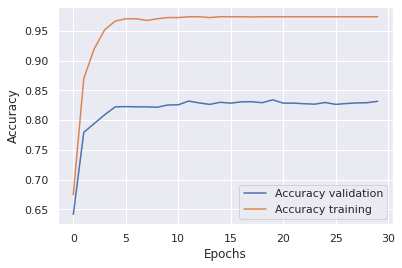

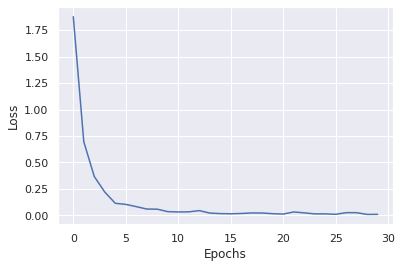

In [0]:
# 3A-B-C
# transfer learning

trainValidateTest("Transfer Learning",pretrainednet, pretrainednet_optimizer, pretrainednet_scheduler, LR, NUM_EPOCHS, STEP_SIZE, img_train_dataloader, img_val_dataloader, img_test_dataloader,img_splitted_train_dataset, img_val_dataset, img_test_dataset)

In [0]:
# 3D - Experiment by training only the fully connected layers (freeze other layers)
#trainValidateTest("Transfer Learning","FC", pretrainednet, LR, NUM_EPOCHS, STEP_SIZE, img_train_dataloader, img_val_dataloader, img_test_dataloader, img_val_dataset, img_test_dataset)



In [0]:
# 3E - Experiment by training only the convolutional layers (freeze other layers)
#trainValidateTest("Transfer Learning","CONVOLUTIONAL", pretrainednet, LR, NUM_EPOCHS, STEP_SIZE, img_train_dataloader, img_val_dataloader, img_test_dataloader, img_val_dataset, img_test_dataset)